<a href="https://colab.research.google.com/github/SuhaniGupta99/pulmonary_embolism_detection/blob/main/Pe_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip rsna_subset_2500.zip

Archive:  rsna_subset_2500.zip
replace rsna_subset_2500/images/000f7f114264/9f7378c3b2ab/6193eb8773cf.dcm? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls rsna_subset_2500

images	labels.csv


In [ ]:
!pip install -q pydicom opencv-python albumentations

In [ ]:
!pip install -q pydicom timm albumentations segmentation-models-pytorch seaborn

In [ ]:
!pip install -q pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg gdcm

In [ ]:
import torch

In [ ]:
import os, cv2
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    confusion_matrix, accuracy_score,
    precision_recall_curve, average_precision_score
)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


Using device: cuda


In [ ]:
IMG_ROOT = "rsna_subset_2500/images"
LABELS_PATH = "rsna_subset_2500/labels.csv"

In [ ]:
df = pd.read_csv(LABELS_PATH)
df["label"] = (df["negative_exam_for_pe"] == 0).astype(int)
print("Total rows:", len(df))

Total rows: 2500


In [ ]:
def series_has_images(study, series):
    p = os.path.join(IMG_ROOT, study, series)
    return os.path.exists(p) and len(glob(p+"/*.dcm")) > 0

mask = [
    series_has_images(r.StudyInstanceUID, r.SeriesInstanceUID)
    for _, r in df.iterrows()
]

df = df[mask].reset_index(drop=True)
print("Usable series:", df.SeriesInstanceUID.nunique())


Usable series: 1858


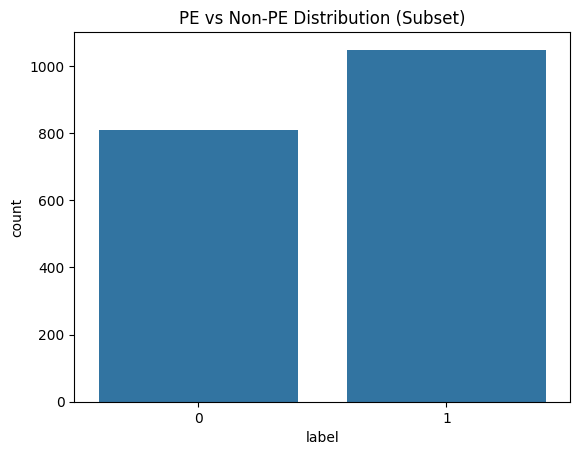

In [ ]:
series_df = df.groupby("SeriesInstanceUID")["label"].first().reset_index()

sns.countplot(x="label", data=series_df)
plt.title("PE vs Non-PE Distribution (Subset)")
plt.show()

In [ ]:
train_ids, val_ids = train_test_split(
    series_df.SeriesInstanceUID,
    test_size=0.2,
    stratify=series_df.label,
    random_state=42
)

train_df = df[df.SeriesInstanceUID.isin(train_ids)]
val_df   = df[df.SeriesInstanceUID.isin(val_ids)]

print("Train series:", train_df.SeriesInstanceUID.nunique())
print("Val series:", val_df.SeriesInstanceUID.nunique())


Train series: 1486
Val series: 372


In [ ]:
def window_ct(img, level=100, width=700):
    low = level - width // 2
    high = level + width // 2
    img = np.clip(img, low, high)
    img = (img - low) / (high - low)
    return img


In [ ]:
import pydicom

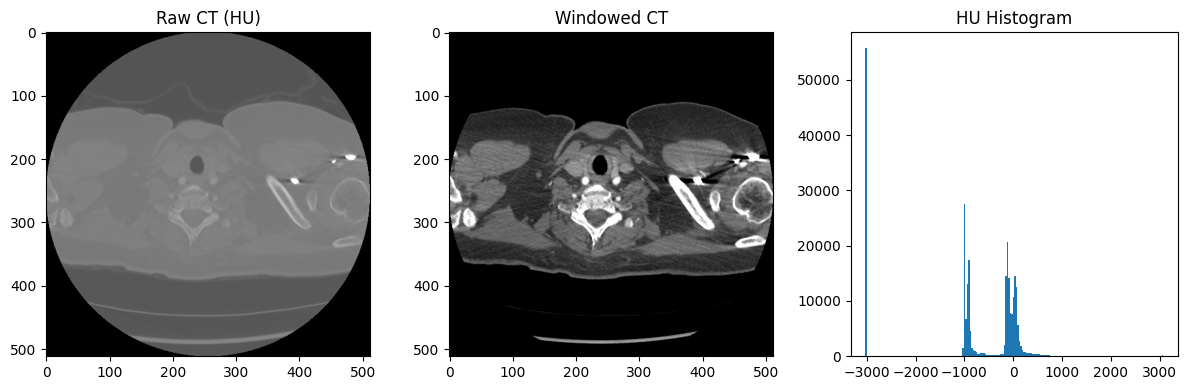

In [ ]:
sample = train_df.iloc[0]
sample_path = glob(
    os.path.join(
        IMG_ROOT,
        sample.StudyInstanceUID,
        sample.SeriesInstanceUID,
        "*.dcm"
    )
)[0]

dcm = pydicom.dcmread(sample_path)
raw = dcm.pixel_array.astype(np.float32)
raw = raw * dcm.RescaleSlope + dcm.RescaleIntercept
win = window_ct(raw)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(raw,cmap="gray"); plt.title("Raw CT (HU)")
plt.subplot(1,3,2); plt.imshow(win,cmap="gray"); plt.title("Windowed CT")
plt.subplot(1,3,3); plt.hist(raw.flatten(), bins=200); plt.title("HU Histogram")
plt.tight_layout(); plt.show()


In [ ]:
class RSNADataset(Dataset):
    def __init__(self, df, stack=2, train=True):
        self.groups = df.groupby("SeriesInstanceUID")
        self.series_ids = list(self.groups.groups.keys())
        self.stack = stack
        self.train = train

    def __len__(self):
        return len(self.series_ids)

    def __getitem__(self, idx):
        sid = self.series_ids[idx]
        g = self.groups.get_group(sid)
        study_uid = g.StudyInstanceUID.iloc[0]

        files = glob(os.path.join(IMG_ROOT, study_uid, sid, "*.dcm"))
        slices = []

        for f in files:
            dcm = pydicom.dcmread(f)
            img = dcm.pixel_array.astype(np.float32)
            img = img * dcm.RescaleSlope + dcm.RescaleIntercept
            z = float(dcm.ImagePositionPatient[2])
            img = window_ct(img)
            img = cv2.resize(img, (224,224))
            slices.append((z, img))

        # sort by physical z-position
        slices = [s[1] for s in sorted(slices, key=lambda x: x[0])]
        n = len(slices)

        # 🔥 SAFE CENTER SELECTION
        if n < 2 * self.stack + 1:
            # too few slices → pad by repeating center
            center = n // 2
            idxs = [center] * (2 * self.stack + 1)
        else:
            center = (
                np.random.randint(self.stack, n - self.stack)
                if self.train else n // 2
            )
            idxs = range(center - self.stack, center + self.stack + 1)

        x = torch.tensor(np.stack([slices[i] for i in idxs])).unsqueeze(1)
        y = torch.tensor(g.label.iloc[0], dtype=torch.float32)

        return x, y


In [ ]:
train_loader = DataLoader(
    RSNADataset(train_df, stack=4, train=True),
    batch_size=4, shuffle=True, num_workers=2
)

val_loader = DataLoader(
    RSNADataset(val_df, stack=4, train=False),
    batch_size=4, shuffle=False, num_workers=2
)


In [ ]:
class UnifiedPEModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = timm.create_model(
            "efficientnet_b2",
            pretrained=True,
            in_chans=1,
            features_only=True
        )

        C = self.encoder.feature_info[-1]["num_chs"]

        # Slice attention
        self.slice_attn = nn.Sequential(
            nn.Linear(C, C//2),
            nn.ReLU(),
            nn.Linear(C//2, 1)
        )

        # Classification head
        self.cls_head = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(C, 1)
        )

        # Weak segmentation head
        self.seg_head = nn.Sequential(
            nn.Conv2d(C, C//2, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(C//2, 1, 1)
        )

        self.feature_maps = None
        self.feature_grads = {}

    def save_grad(self, idx):
        def hook(grad):
            self.feature_grads[idx] = grad
        return hook

    def forward(self, x):

        B, S, C, H, W = x.shape
        x = x.view(B*S, C, H, W)

        feats = self.encoder(x)

        self.feature_maps = feats
        self.feature_grads = {}

        if torch.is_grad_enabled():
            for i, f in enumerate(feats):
                f.register_hook(self.save_grad(i))

        feat = feats[-1].view(
            B, S,
            feats[-1].shape[1],
            feats[-1].shape[2],
            feats[-1].shape[3]
        )

        pooled = feat.mean(dim=(3,4))
        attn = torch.softmax(self.slice_attn(pooled), dim=1)
        feat = (feat * attn.unsqueeze(-1).unsqueeze(-1)).sum(dim=1)

        cls = self.cls_head(
            F.adaptive_avg_pool2d(feat,1).flatten(1)
        ).squeeze(1)

        seg = self.seg_head(feat)
        seg_up = F.interpolate(seg, (224,224), mode="bilinear")

        return cls, seg_up


In [ ]:
class MultiScaleGradCAM:
    def __init__(self, model, scales=(1,2,3)):
        self.model = model
        self.scales = scales

    def generate(self, x):
        self.model.zero_grad()
        cls,_ = self.model(x)
        cls.mean().backward(retain_graph=True)

        cams=[]
        for i in self.scales:
            act = self.model.feature_maps[i]
            grad = self.model.feature_grads[i]
            w = grad.mean(dim=(2,3),keepdim=True)
            cam = F.relu((w*act).sum(1,keepdim=True))
            cam = F.interpolate(cam,(224,224))
            cams.append(cam)

        cam = torch.mean(torch.stack(cams),0)
        return cam/(cam.max()+1e-8)


In [ ]:
import timm

In [ ]:
num_pos = (train_df.label == 1).sum()
num_neg = (train_df.label == 0).sum()

pos_weight = torch.tensor([num_neg / num_pos]).to(DEVICE)


In [ ]:
cls_loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
seg_loss_fn = nn.BCEWithLogitsLoss()

def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    inter = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    dice = (2 * inter + smooth) / (union + smooth)
    return 1 - dice.mean()


In [ ]:
model = UnifiedPEModel().to(DEVICE)
cam_gen = MultiScaleGradCAM(model)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
scaler = torch.amp.GradScaler("cuda")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

In [ ]:
EPOCHS = 50
train_losses = []

for epoch in range(EPOCHS):

    model.train()
    total = 0

    if epoch < 5:
        seg_weight = 0.0
    elif epoch < 15:
        seg_weight = 0.05
    else:
        seg_weight = 0.1

    print(f"\nEpoch {epoch+1}/{EPOCHS} | Seg Weight: {seg_weight}")

    for x, y in tqdm(train_loader):

        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()

        with torch.amp.autocast("cuda"):

            cls, seg = model(x)
            cls_loss = cls_loss_fn(cls, y)

            if seg_weight > 0:

                cam = cam_gen.generate(x)

                B, S = x.shape[0], x.shape[1]
                cam = cam.view(B, S, 1, 224, 224).mean(1)

                cam_min = cam.view(B, -1).min(dim=1)[0].view(B,1,1,1)
                cam_max = cam.view(B, -1).max(dim=1)[0].view(B,1,1,1)
                cam_n = (cam - cam_min) / (cam_max - cam_min + 1e-8)

                with torch.no_grad():
                    pseudo_mask = (cam_n > 0.35).float()

                pe = y.view(-1,1,1,1)

                seg_bce = seg_loss_fn(seg * pe, pseudo_mask * pe)
                seg_dice = dice_loss(seg * pe, pseudo_mask * pe)

                seg_loss = seg_bce + seg_dice

                loss = cls_loss + seg_weight * seg_loss

            else:
                loss = cls_loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total += loss.item()

    scheduler.step()
    train_losses.append(total / len(train_loader))

    print(f"Epoch {epoch+1} Loss: {train_losses[-1]:.4f}")



Epoch 1/50 | Seg Weight: 0.0


100%|██████████| 372/372 [01:23<00:00,  4.45it/s]


Epoch 1 Loss: 0.4971

Epoch 2/50 | Seg Weight: 0.0


100%|██████████| 372/372 [00:58<00:00,  6.32it/s]


Epoch 2 Loss: 0.4621

Epoch 3/50 | Seg Weight: 0.0


100%|██████████| 372/372 [00:57<00:00,  6.42it/s]


Epoch 3 Loss: 0.4106

Epoch 4/50 | Seg Weight: 0.0


100%|██████████| 372/372 [00:57<00:00,  6.44it/s]


Epoch 4 Loss: 0.3731

Epoch 5/50 | Seg Weight: 0.0


100%|██████████| 372/372 [00:57<00:00,  6.43it/s]


Epoch 5 Loss: 0.3474

Epoch 6/50 | Seg Weight: 0.05


100%|██████████| 372/372 [01:51<00:00,  3.34it/s]


Epoch 6 Loss: 0.3340

Epoch 7/50 | Seg Weight: 0.05


100%|██████████| 372/372 [01:50<00:00,  3.36it/s]


Epoch 7 Loss: 0.3027

Epoch 8/50 | Seg Weight: 0.05


100%|██████████| 372/372 [01:51<00:00,  3.34it/s]


Epoch 8 Loss: 0.2953

Epoch 9/50 | Seg Weight: 0.05


100%|██████████| 372/372 [01:50<00:00,  3.36it/s]


Epoch 9 Loss: 0.2676

Epoch 10/50 | Seg Weight: 0.05


100%|██████████| 372/372 [01:51<00:00,  3.35it/s]


Epoch 10 Loss: 0.2590

Epoch 11/50 | Seg Weight: 0.05


100%|██████████| 372/372 [01:51<00:00,  3.35it/s]


Epoch 11 Loss: 0.2549

Epoch 12/50 | Seg Weight: 0.05


100%|██████████| 372/372 [01:51<00:00,  3.35it/s]


Epoch 12 Loss: 0.2496

Epoch 13/50 | Seg Weight: 0.05


100%|██████████| 372/372 [01:50<00:00,  3.35it/s]


Epoch 13 Loss: 0.2210

Epoch 14/50 | Seg Weight: 0.05


100%|██████████| 372/372 [01:51<00:00,  3.34it/s]


Epoch 14 Loss: 0.2397

Epoch 15/50 | Seg Weight: 0.05


100%|██████████| 372/372 [01:51<00:00,  3.34it/s]


Epoch 15 Loss: 0.1969

Epoch 16/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:51<00:00,  3.35it/s]


Epoch 16 Loss: 0.2884

Epoch 17/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:51<00:00,  3.34it/s]


Epoch 17 Loss: 0.2843

Epoch 18/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:51<00:00,  3.34it/s]


Epoch 18 Loss: 0.2843

Epoch 19/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:51<00:00,  3.35it/s]


Epoch 19 Loss: 0.2875

Epoch 20/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:51<00:00,  3.34it/s]


Epoch 20 Loss: 0.2532

Epoch 21/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:51<00:00,  3.35it/s]


Epoch 21 Loss: 0.2664

Epoch 22/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:51<00:00,  3.34it/s]


Epoch 22 Loss: 0.2627

Epoch 23/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:51<00:00,  3.34it/s]


Epoch 23 Loss: 0.2953

Epoch 24/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:50<00:00,  3.36it/s]


Epoch 24 Loss: 0.2562

Epoch 25/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:51<00:00,  3.34it/s]


Epoch 25 Loss: 0.2657

Epoch 26/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:51<00:00,  3.35it/s]


Epoch 26 Loss: 0.2586

Epoch 27/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:50<00:00,  3.36it/s]


Epoch 27 Loss: 0.2473

Epoch 28/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:51<00:00,  3.34it/s]


Epoch 28 Loss: 0.2235

Epoch 29/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:50<00:00,  3.35it/s]


Epoch 29 Loss: 0.2555

Epoch 30/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:50<00:00,  3.36it/s]


Epoch 30 Loss: 0.2357

Epoch 31/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:50<00:00,  3.36it/s]


Epoch 31 Loss: 0.2416

Epoch 32/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:51<00:00,  3.35it/s]


Epoch 32 Loss: 0.2527

Epoch 33/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:50<00:00,  3.36it/s]


Epoch 33 Loss: 0.2337

Epoch 34/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:50<00:00,  3.36it/s]


Epoch 34 Loss: 0.2378

Epoch 35/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:50<00:00,  3.35it/s]


Epoch 35 Loss: 0.2638

Epoch 36/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:50<00:00,  3.36it/s]


Epoch 36 Loss: 0.2302

Epoch 37/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:50<00:00,  3.36it/s]


Epoch 37 Loss: 0.2465

Epoch 38/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:51<00:00,  3.35it/s]


Epoch 38 Loss: 0.2405

Epoch 39/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:51<00:00,  3.34it/s]


Epoch 39 Loss: 0.2316

Epoch 40/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:50<00:00,  3.35it/s]


Epoch 40 Loss: 0.2328

Epoch 41/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:50<00:00,  3.36it/s]


Epoch 41 Loss: 0.2357

Epoch 42/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:50<00:00,  3.36it/s]


Epoch 42 Loss: 0.2395

Epoch 43/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:50<00:00,  3.35it/s]


Epoch 43 Loss: 0.2309

Epoch 44/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:50<00:00,  3.35it/s]


Epoch 44 Loss: 0.2666

Epoch 45/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:51<00:00,  3.35it/s]


Epoch 45 Loss: 0.2382

Epoch 46/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:50<00:00,  3.35it/s]


Epoch 46 Loss: 0.2299

Epoch 47/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:50<00:00,  3.36it/s]


Epoch 47 Loss: 0.2116

Epoch 48/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:51<00:00,  3.35it/s]


Epoch 48 Loss: 0.2307

Epoch 49/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:51<00:00,  3.35it/s]


Epoch 49 Loss: 0.2407

Epoch 50/50 | Seg Weight: 0.1


100%|██████████| 372/372 [01:51<00:00,  3.34it/s]

Epoch 50 Loss: 0.2264


In [ ]:
model.eval()
y_true, y_prob = [], []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(DEVICE)
        cls, _ = model(x)

        y_true.extend(y.numpy())
        y_prob.extend(torch.sigmoid(cls).cpu().numpy())

auc = roc_auc_score(y_true, y_prob)
print("Validation AUROC:", auc)

y_pred = (np.array(y_prob) > 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Sensitivity:", tp/(tp+fn+1e-8))
print("Specificity:", tn/(tn+fp+1e-8))


Validation AUROC: 0.7636684303350971
Accuracy: 0.6747311827956989
Sensitivity: 0.6095238094947846
Specificity: 0.7592592592123913


In [ ]:
x, y = next(iter(val_loader))
x = x.to(DEVICE)

model.eval()

cls, seg = model(x)
cam = cam_gen.generate(x)

with torch.no_grad():
    seg_out = torch.sigmoid(seg)

B, S = x.shape[0], x.shape[1]
cam = cam.view(B, S, 1, 224, 224).mean(1)

plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.imshow(x[0,2,0].cpu(), cmap="gray")
plt.title("CT")

plt.subplot(1,3,2)
plt.imshow(cam[0,0].detach().cpu(), cmap="jet")
plt.title("Pseudo Mask (CAM)")

plt.subplot(1,3,3)
plt.imshow(seg_out[0,0].cpu(), cmap="jet")
plt.title("Weak Segmentation")

plt.show()


Accuracy: 0.6747311827956989
Sensitivity: 0.6095238094947846
Specificity: 0.7592592592123913


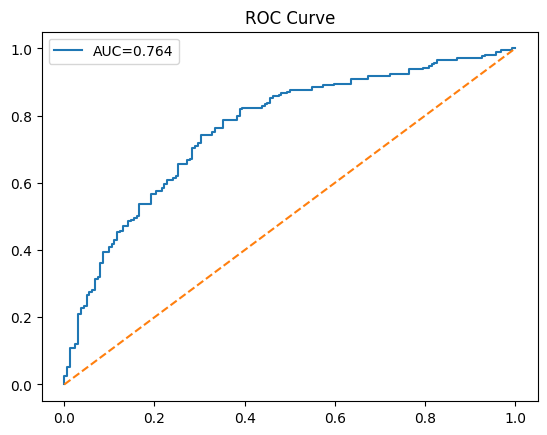

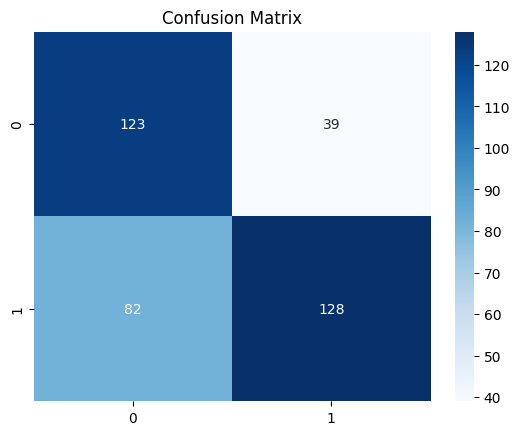

In [ ]:
y_pred=(np.array(y_prob)>0.5).astype(int)
cm=confusion_matrix(y_true,y_pred)
tn,fp,fn,tp=cm.ravel()

print("Accuracy:", accuracy_score(y_true,y_pred))
print("Sensitivity:", tp/(tp+fn+1e-8))
print("Specificity:", tn/(tn+fp+1e-8))

fpr,tpr,_=roc_curve(y_true,y_prob)
plt.plot(fpr,tpr,label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.legend(); plt.title("ROC Curve"); plt.show()


cm = confusion_matrix(y_true,(np.array(y_pred)>0.5).astype(int))
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.title("Confusion Matrix"); plt.show()


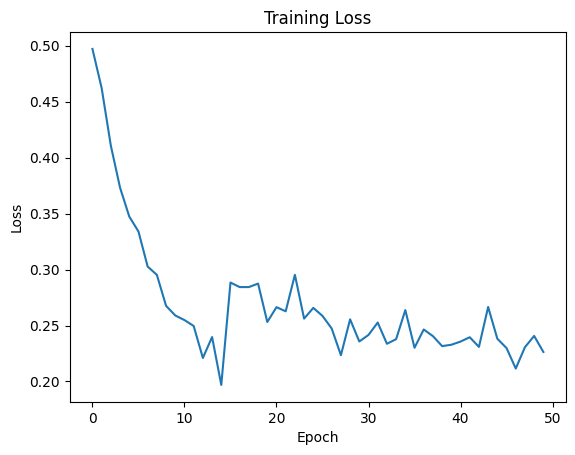

In [ ]:
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()


In [ ]:
x, y = next(iter(val_loader))
x = x.to(DEVICE)

cam = cam_gen.generate(x)
_, det = model(x)
det_up = F.interpolate(det, (224,224), mode="bilinear")

plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.imshow(x[0,2,0].detach().cpu(), cmap="gray")
plt.title("CT")

plt.subplot(1,3,2)
plt.imshow(cam[0,0].detach().cpu(), cmap="jet")
plt.title("CAM")

plt.subplot(1,3,3)
plt.imshow(det_up[0,0].detach().cpu(), cmap="jet")
plt.title("Detection")

plt.show()


In [ ]:
model.eval()
y_true, y_prob = [], []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(DEVICE)
        cls, _ = model(x)
        y_true.extend(y.numpy())
        y_prob.extend(torch.sigmoid(cls).cpu().numpy())

y_true = np.array(y_true)
y_prob = np.array(y_prob)


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_true, y_prob)
ap = average_precision_score(y_true, y_prob)

plt.figure()
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall (Sensitivity)")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
val_losses = []

model.eval()
with torch.no_grad():
    total = 0
    for x, y in val_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        cls, _ = model(x)
        total += cls_loss_fn(cls, y).item()

val_losses.append(total / len(val_loader))

plt.figure()
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def iou(cam, det, thr=0.35):
    cam_bin = cam > thr
    det_bin = det > thr
    inter = (cam_bin & det_bin).sum()
    union = (cam_bin | det_bin).sum()
    return (inter / union).item() if union > 0 else 0.0

ious = []

model.eval()
for x, y in val_loader:
    x = x.to(DEVICE)

    cam = cam_gen.generate(x)
    _, det = model(x)

    B, S = x.shape[0], x.shape[1]
    cam = cam.view(B, S, 1, 224, 224).mean(1)
    det_up = F.interpolate(det, (224,224))

    for i in range(B):
        ious.append(iou(cam[i].detach().cpu(), det_up[i].detach().cpu()))

plt.figure()
plt.hist(ious, bins=20)
plt.xlabel("IoU (CAM vs Detection)")
plt.ylabel("Frequency")
plt.title("CAM–Detection Overlap Distribution")
plt.grid(True)
plt.show()


In [ ]:
plt.figure()
sns.kdeplot(y_prob[y_true == 1], label="PE", fill=True)
sns.kdeplot(y_prob[y_true == 0], label="No PE", fill=True)
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.title("Prediction Score Distribution")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix

thresholds = np.linspace(0, 1, 50)
sens_list, spec_list, acc_list = [], [], []

for t in thresholds:
    preds = (y_prob > t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()

    sens_list.append(tp / (tp + fn + 1e-8))
    spec_list.append(tn / (tn + fp + 1e-8))
    acc_list.append((tp + tn) / (tp + tn + fp + fn))

plt.figure()
plt.plot(thresholds, sens_list, label="Sensitivity")
plt.plot(thresholds, spec_list, label="Specificity")
plt.plot(thresholds, acc_list, label="Accuracy")
plt.xlabel("Decision Threshold")
plt.ylabel("Metric Value")
plt.title("Threshold Sensitivity Analysis")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thr = roc_curve(y_true, y_prob)
youden = tpr - fpr
best_idx = np.argmax(youden)

best_thr = thr[best_idx]
best_sens = tpr[best_idx]
best_spec = 1 - fpr[best_idx]

print(f"Optimal threshold (Youden): {best_thr:.3f}")
print(f"Sensitivity: {best_sens:.3f}")
print(f"Specificity: {best_spec:.3f}")
